In [1]:
!git clone -b update-gluonts https://github.com/time-series-foundation-models/lag-llama/

Cloning into 'lag-llama'...
remote: Enumerating objects: 505, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 505 (delta 154), reused 109 (delta 109), pack-reused 312 (from 3)
Receiving objects: 100% (505/505), 283.34 KiB | 17.71 MiB/s, done.
Resolving deltas: 100% (252/252), done.


In [2]:
cd /content/lag-llama

/content/lag-llama


In [3]:
!pip uninstall jax jaxlib tensorboard -y

Found existing installation: jax 0.5.2
Uninstalling jax-0.5.2:
  Successfully uninstalled jax-0.5.2
Found existing installation: jaxlib 0.5.1
Uninstalling jaxlib-0.5.1:
  Successfully uninstalled jaxlib-0.5.1
Found existing installation: tensorboard 2.18.0
Uninstalling tensorboard-2.18.0:
  Successfully uninstalled tensorboard-2.18.0


In [4]:
!pip install -U -r requirements.txt --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.

In [5]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir /content/lag-llama

lag-llama.ckpt: 100% 29.5M/29.5M [00:00<00:00, 207MB/s]
Download complete. Moving file to /content/lag-llama/lag-llama.ckpt
/content/lag-llama/lag-llama.ckpt


## Imports

We import the required packages and the lag llama estimator object which we can use to make predictions.

In [6]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from tqdm.autonotebook import tqdm

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator

<ipython-input-6-3749d135369e>:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [7]:
import sys
from types import ModuleType

# Create dummy module hierarchy
def create_dummy_module(module_path):
    """
    Create a dummy module hierarchy for the given path.
    Returns the leaf module.
    """
    parts = module_path.split('.')
    current = ''
    parent = None

    for part in parts:
        current = current + '.' + part if current else part
        if current not in sys.modules:
            module = ModuleType(current)
            sys.modules[current] = module
            if parent:
                setattr(sys.modules[parent], part, module)
        parent = current

    return sys.modules[module_path]

# Create the dummy gluonts module hierarchy
gluonts_module = create_dummy_module('gluonts.torch.modules.loss')

# Create dummy classes for the specific loss functions
class DistributionLoss:
    def __init__(self, *args, **kwargs):
        pass

    def __call__(self, *args, **kwargs):
        return 0.0

    def __getattr__(self, name):
        return lambda *args, **kwargs: None

class NegativeLogLikelihood:
    def __init__(self, *args, **kwargs):
        pass

    def __call__(self, *args, **kwargs):
        return 0.0

    def __getattr__(self, name):
        return lambda *args, **kwargs: None

# Add the specific classes to the module
gluonts_module.DistributionLoss = DistributionLoss
gluonts_module.NegativeLogLikelihood = NegativeLogLikelihood

In [8]:
'''def get_lag_llama_predictions(dataset, prediction_length, context_length=32, num_samples=20, device="cuda", batch_size=64, nonnegative_pred_samples=True):
    ckpt = torch.load("lag-llama.ckpt", map_location=device, weights_only=False)
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],

        nonnegative_pred_samples=nonnegative_pred_samples,

        # linear positional encoding scaling
        rope_scaling={
            "type": "linear",
            "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        },

        batch_size=batch_size,
        num_parallel_samples=num_samples,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(tqdm(forecast_it, total=len(dataset), desc="Forecasting batches"))
    tss = list(tqdm(ts_it, total=len(dataset), desc="Ground truth"))

    return forecasts, tss'''

'def get_lag_llama_predictions(dataset, prediction_length, context_length=32, num_samples=20, device="cuda", batch_size=64, nonnegative_pred_samples=True):\n    ckpt = torch.load("lag-llama.ckpt", map_location=device, weights_only=False)\n    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]\n\n    estimator = LagLlamaEstimator(\n        ckpt_path="lag-llama.ckpt",\n        prediction_length=prediction_length,\n        context_length=context_length,\n\n        # estimator args\n        input_size=estimator_args["input_size"],\n        n_layer=estimator_args["n_layer"],\n        n_embd_per_head=estimator_args["n_embd_per_head"],\n        n_head=estimator_args["n_head"],\n        scaling=estimator_args["scaling"],\n        time_feat=estimator_args["time_feat"],\n\n        nonnegative_pred_samples=nonnegative_pred_samples,\n\n        # linear positional encoding scaling\n        rope_scaling={\n            "type": "linear",\n            "factor": max(1.0, (context_length + predict

## Fine-tuning

Let us fine-tune the Lag-Llama base model with a few data-specific changes. Feel Free to change the hyperparameters below:

In [9]:
# prompt: connect to drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [10]:
import pandas as pd

data_dir = '/content/drive/MyDrive/batteries/total/b1c0_for_model.csv'  # adjust if needed
df_mine = pd.read_csv(data_dir, parse_dates=True)
df_mine

,cycle_index,charge_capacity,discharge_capacity,internal_resistance,temperature_mean,temperature_min,temperature_max
0,3.0,1.071674,1.071900,0.016724,31.931490,29.604385,35.692978
1,4.0,1.072304,1.072510,0.016681,31.932603,29.744202,35.680588
2,5.0,1.072970,1.073174,0.016662,31.959322,29.644709,35.728691
3,6.0,1.073491,1.073576,0.016623,31.961062,29.752932,35.711758
4,7.0,1.073922,1.073992,0.016600,31.900562,29.564377,35.615650
...,...,...,...,...,...,...,...
1844,1847.0,0.885568,0.885435,0.018263,32.432079,31.080084,35.415527
1845,1848.0,0.884639,0.884546,0.018619,31.683310,28.951157,36.136974
1846,1849.0,0.884495,0.884624,0.018133,32.700542,30.243074,36.786781
1847,1850.0,0.884329,0.884331,0.018123,32.990592,30.337559,36.923153


In [11]:

# 1) Imports
import os, glob
import pandas as pd
from sklearn.model_selection import train_test_split
from gluonts.dataset.pandas import PandasDataset
import torch

# 2) Directory with your per-cycle CSVs
data_dir = '/content/drive/MyDrive/batteries/total'  # adjust as needed
files = glob.glob(os.path.join(data_dir, '*_for_model.csv'))
if not files:
    raise FileNotFoundError(f"No CSVs found in {data_dir}")

# 3) Load each CSV into dfs_dict
dfs_dict = {}
for fp in files:
    series_id = os.path.basename(fp).replace('_for_model.csv','')
    df = pd.read_csv(fp)
    df['timestamp'] = pd.to_datetime(df['cycle_index'], unit='D', origin=pd.Timestamp("2000-01-01"))
    df = df.set_index('timestamp').drop(columns=['cycle_index']).astype('float32')
    dfs_dict[series_id] = df

# 4) Split series IDs
all_ids = sorted(dfs_dict)
train_ids, test_ids = train_test_split(all_ids, train_size=100, random_state=42)


# 5) Build PandasDatasets
sensor_cols = ['charge_capacity',
 'discharge_capacity',
 'internal_resistance',
 'temperature_mean',
 'temperature_min',
 'temperature_max']

def build_pds(split_ids):
    subset = {sid: dfs_dict[sid] for sid in split_ids}
    return subset #PandasDataset(dataframes=subset, target=sensor_cols, freq="1D")

train_ds = build_pds(train_ids)
test_ds  = build_pds(test_ids)



# 7) Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 8) Summary
print(f"Train dataset:      {len(train_ds)} series")

print(f"Test dataset:       {len(test_ds)} series")
print(f"Using device:       {device}")


Train dataset:      100 series
Test dataset:       24 series
Using device:       cuda:0


In [14]:
# Initial parameters
prediction_length = 8
initial_epochs = 10
epoch_decay = 0.95
learning_rate = 1e-3
context_length = 128
num_samples = 20
device = "cuda"

In [13]:
import random
batch_ids = random.sample(list(train_ids), 100)

In [ ]:
train_ds['b3c0']

,charge_capacity,discharge_capacity,internal_resistance,temperature_mean,temperature_min,temperature_max
timestamp,,,,,,
2000-01-04,1.067611,1.068285,0.015365,32.088512,30.824745,33.325268
2000-01-05,1.068164,1.068708,0.015326,32.086308,30.804544,33.304203
2000-01-06,1.068695,1.069094,0.015309,32.041145,30.791834,33.257191
2000-01-07,1.068945,1.069415,0.015302,32.014179,30.691322,33.294998
2000-01-08,1.069392,1.069731,0.015286,32.047485,30.734112,33.306644
...,...,...,...,...,...,...
2002-10-01,0.917883,0.916981,0.016102,33.193604,31.565229,34.829807
2002-10-02,0.917883,0.916981,0.016102,33.107368,31.424242,34.779549
2002-10-03,0.917883,0.916981,0.016102,33.041687,31.382666,34.779041


In [15]:
from pytorch_lightning import Trainer

prev_ckpt_path = "lag-llama.ckpt"


# Incremental training loop
for i, sid in enumerate(batch_ids):
    df = train_ds[sid]
    ds = PandasDataset(dict(df))

    current_epochs = max(2, int(initial_epochs * (epoch_decay ** i)))  # Gradually reduce epochs

    ckpt = torch.load(prev_ckpt_path, map_location=device, weights_only=False)
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    print(f"Checkpoint being used: {prev_ckpt_path}")



    print(f"Training on batch {i+1}/{len(batch_ids)} | Epochs: {current_epochs} | Batch ID: {sid}")

    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }


    estimator = LagLlamaEstimator(
        ckpt_path=prev_ckpt_path,
        prediction_length=prediction_length,
        context_length=context_length,
        num_parallel_samples=num_samples,
        trainer_kwargs={
        "max_epochs": current_epochs},

        # distr_output="neg_bin",
        # scaling="mean",
        nonnegative_pred_samples=True,
        aug_prob=0,
        lr=1e-3,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        time_feat=estimator_args["time_feat"],
        batch_size=64,
        rope_scaling=rope_scaling_arguments

    )


    predictor = estimator.train(ds, cache_data=True, shuffle_buffer_length=1000)

    list_of_checkpoints = glob.glob(os.path.join('/content/lag-llama/lightning_logs/', '**', '*.ckpt'), recursive=True)
    if not list_of_checkpoints:
        print("Warning: No checkpoint found after training. Using previous checkpoint path.")
        # If no new checkpoint is found, keep the previous path, or handle appropriately
        # (e.g., if training failed or epoch=0)
    else:
        # Sort checkpoints by modification time to get the latest one
        latest_checkpoint = max(list_of_checkpoints, key=os.path.getmtime)
        prev_ckpt_path = latest_checkpoint
        print(f"Found latest checkpoint: {prev_ckpt_path}")



print(f"\nIncremental training finished. Final checkpoint path: {prev_ckpt_path}")


Checkpoint being used: lag-llama.ckpt
Training on batch 1/100 | Epochs: 10 | Batch ID: b3c5


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached 2.06462 (best 2.06462), saving model to '/content/lag-llama/lightning_logs/version_0/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -0.07658 (best -0.07658), saving model to '/content/lag-llama/lightning_logs/version_0/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' reached -0.39331 (best -0.39331), saving model to '/content/lag-llama/lightning_logs/version_0/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 200: 'train_loss' reached -0.56371 (best -0.56371), saving model to '/content/lag-llama/lightning_logs/version_0/checkpoints/epoch=3-step=200.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 250: 'train_loss' reached -0.59380 (best -0.59380), savi

Found latest checkpoint: /content/lag-llama/lightning_logs/version_0/checkpoints/epoch=8-step=450.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_0/checkpoints/epoch=8-step=450.ckpt
Training on batch 2/100 | Epochs: 9 | Batch ID: b2c47


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached 0.03804 (best 0.03804), saving model to '/content/lag-llama/lightning_logs/version_1/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -1.24844 (best -1.24844), saving model to '/content/lag-llama/lightning_logs/version_1/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 200: 'train_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 250: 'train_loss' reached -1.28206 (best -1.28206), saving model to '/content/lag-llama/lightning_logs/version_1/checkpoints/epoch=4-step=250.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 300: 'train_loss' reached -1.89333 (best -1.89333), saving model to '/content/l

Found latest checkpoint: /content/lag-llama/lightning_logs/version_1/checkpoints/epoch=5-step=300.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_1/checkpoints/epoch=5-step=300.ckpt
Training on batch 3/100 | Epochs: 9 | Batch ID: b2c38


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached 0.41255 (best 0.41255), saving model to '/content/lag-llama/lightning_logs/version_2/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -1.42283 (best -1.42283), saving model to '/content/lag-llama/lightning_logs/version_2/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' reached -1.61570 (best -1.61570), saving model to '/content/lag-llama/lightning_logs/version_2/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 200: 'train_loss' reached -1.61850 (best -1.61850), saving model to '/content/lag-llama/lightning_logs/version_2/checkpoints/epoch=3-step=200.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 250: 'train_loss' reached -1.80946 (best -1.80946), savi

Found latest checkpoint: /content/lag-llama/lightning_logs/version_2/checkpoints/epoch=5-step=300.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_2/checkpoints/epoch=5-step=300.ckpt
Training on batch 4/100 | Epochs: 8 | Batch ID: b1c35


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -0.74372 (best -0.74372), saving model to '/content/lag-llama/lightning_logs/version_3/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -1.24081 (best -1.24081), saving model to '/content/lag-llama/lightning_logs/version_3/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' reached -1.53140 (best -1.53140), saving model to '/content/lag-llama/lightning_logs/version_3/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 200: 'train_loss' reached -1.66155 (best -1.66155), saving model to '/content/lag-llama/lightning_logs/version_3/checkpoints/epoch=3-step=200.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 250: 'train_loss' reached -1.91245 (best -1.91245), sa

Found latest checkpoint: /content/lag-llama/lightning_logs/version_3/checkpoints/epoch=6-step=350.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_3/checkpoints/epoch=6-step=350.ckpt
Training on batch 5/100 | Epochs: 8 | Batch ID: b2c31


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -0.84263 (best -0.84263), saving model to '/content/lag-llama/lightning_logs/version_4/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -1.80209 (best -1.80209), saving model to '/content/lag-llama/lightning_logs/version_4/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' reached -2.09402 (best -2.09402), saving model to '/content/lag-llama/lightning_logs/version_4/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 200: 'train_loss' reached -2.11068 (best -2.11068), saving model to '/content/lag-llama/lightning_logs/version_4/checkpoints/epoch=3-step=200.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 250: 'train_loss' reached -2.25886 (best -2.25886), sa

Found latest checkpoint: /content/lag-llama/lightning_logs/version_4/checkpoints/epoch=6-step=350.ckpt


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Checkpoint being used: /content/lag-llama/lightning_logs/version_4/checkpoints/epoch=6-step=350.ckpt
Training on batch 6/100 | Epochs: 7 | Batch ID: b1c19


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -0.68532 (best -0.68532), saving model to '/content/lag-llama/lightning_logs/version_5/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -1.08157 (best -1.08157), saving model to '/content/lag-llama/lightning_logs/version_5/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 200: 'train_loss' reached -1.59414 (best -1.59414), saving model to '/content/lag-llama/lightning_logs/version_5/checkpoints/epoch=3-step=200.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 250: 'train_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 300: 'train_loss' reached -1.79144 (best -1.79144), saving model to '/content

Found latest checkpoint: /content/lag-llama/lightning_logs/version_5/checkpoints/epoch=6-step=350.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_5/checkpoints/epoch=6-step=350.ckpt
Training on batch 7/100 | Epochs: 7 | Batch ID: b3c35


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -0.40056 (best -0.40056), saving model to '/content/lag-llama/lightning_logs/version_6/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -1.85925 (best -1.85925), saving model to '/content/lag-llama/lightning_logs/version_6/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' reached -1.88150 (best -1.88150), saving model to '/content/lag-llama/lightning_logs/version_6/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 200: 'train_loss' reached -2.22351 (best -2.22351), saving model to '/content/lag-llama/lightning_logs/version_6/checkpoints/epoch=3-step=200.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 250: 'train_loss' reached -2.46234 (best -2.46234), sa

Found latest checkpoint: /content/lag-llama/lightning_logs/version_6/checkpoints/epoch=5-step=300.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_6/checkpoints/epoch=5-step=300.ckpt
Training on batch 8/100 | Epochs: 6 | Batch ID: b2c29


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -0.48658 (best -0.48658), saving model to '/content/lag-llama/lightning_logs/version_7/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -1.98893 (best -1.98893), saving model to '/content/lag-llama/lightning_logs/version_7/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' reached -2.04494 (best -2.04494), saving model to '/content/lag-llama/lightning_logs/version_7/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 200: 'train_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 250: 'train_loss' reached -2.24744 (best -2.24744), saving model to '/content/lag-llama/lightning_logs/version_7/checkpoints/epoch=4-step=250.ckpt' as top 1
INFO:pytorch_lightn

Found latest checkpoint: /content/lag-llama/lightning_logs/version_7/checkpoints/epoch=4-step=250.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_7/checkpoints/epoch=4-step=250.ckpt
Training on batch 9/100 | Epochs: 6 | Batch ID: b1c34


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -0.71684 (best -0.71684), saving model to '/content/lag-llama/lightning_logs/version_8/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -1.88406 (best -1.88406), saving model to '/content/lag-llama/lightning_logs/version_8/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' reached -2.03736 (best -2.03736), saving model to '/content/lag-llama/lightning_logs/version_8/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 200: 'train_loss' reached -2.09252 (best -2.09252), saving model to '/content/lag-llama/lightning_logs/version_8/checkpoints/epoch=3-step=200.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 250: 'train_loss' was not in top 1
INFO:pytorch_lightn

Found latest checkpoint: /content/lag-llama/lightning_logs/version_8/checkpoints/epoch=5-step=300.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_8/checkpoints/epoch=5-step=300.ckpt
Training on batch 10/100 | Epochs: 6 | Batch ID: b1c5


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.07437 (best -1.07437), saving model to '/content/lag-llama/lightning_logs/version_9/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.13289 (best -2.13289), saving model to '/content/lag-llama/lightning_logs/version_9/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' reached -2.24971 (best -2.24971), saving model to '/content/lag-llama/lightning_logs/version_9/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 200: 'train_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 250: 'train_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 300: 'train_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero

Found latest checkpoint: /content/lag-llama/lightning_logs/version_9/checkpoints/epoch=2-step=150.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_9/checkpoints/epoch=2-step=150.ckpt
Training on batch 11/100 | Epochs: 5 | Batch ID: b3c33


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.03581 (best -1.03581), saving model to '/content/lag-llama/lightning_logs/version_10/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -1.86449 (best -1.86449), saving model to '/content/lag-llama/lightning_logs/version_10/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' reached -2.26745 (best -2.26745), saving model to '/content/lag-llama/lightning_logs/version_10/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 200: 'train_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 250: 'train_loss' reached -2.58477 (best -2.58477), saving model to '/content/lag-llama/lightning_logs/version_10/checkpoints/epoch=4-step=250.ckpt' as top 1
INFO:pytorch_li

Found latest checkpoint: /content/lag-llama/lightning_logs/version_10/checkpoints/epoch=4-step=250.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_10/checkpoints/epoch=4-step=250.ckpt
Training on batch 12/100 | Epochs: 5 | Batch ID: b2c5


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -0.84416 (best -0.84416), saving model to '/content/lag-llama/lightning_logs/version_11/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.12808 (best -2.12808), saving model to '/content/lag-llama/lightning_logs/version_11/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' reached -2.22039 (best -2.22039), saving model to '/content/lag-llama/lightning_logs/version_11/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 200: 'train_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 250: 'train_loss' reached -2.42872 (best -2.42872), saving model to '/content/lag-llama/lightning_logs/version_11/checkpoints/epoch=4-step=250.ckpt' as top 1
INFO:pytorch_li

Found latest checkpoint: /content/lag-llama/lightning_logs/version_11/checkpoints/epoch=4-step=250.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_11/checkpoints/epoch=4-step=250.ckpt
Training on batch 13/100 | Epochs: 5 | Batch ID: b1c17


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.09072 (best -1.09072), saving model to '/content/lag-llama/lightning_logs/version_12/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -1.46841 (best -1.46841), saving model to '/content/lag-llama/lightning_logs/version_12/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' reached -1.95478 (best -1.95478), saving model to '/content/lag-llama/lightning_logs/version_12/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 200: 'train_loss' reached -2.15255 (best -2.15255), saving model to '/content/lag-llama/lightning_logs/version_12/checkpoints/epoch=3-step=200.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 250: 'train_loss' was not in top 1
INFO:pytorch_li

Found latest checkpoint: /content/lag-llama/lightning_logs/version_12/checkpoints/epoch=3-step=200.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_12/checkpoints/epoch=3-step=200.ckpt
Training on batch 14/100 | Epochs: 5 | Batch ID: b3c9


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -2.14760 (best -2.14760), saving model to '/content/lag-llama/lightning_logs/version_13/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.76849 (best -2.76849), saving model to '/content/lag-llama/lightning_logs/version_13/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' reached -2.82845 (best -2.82845), saving model to '/content/lag-llama/lightning_logs/version_13/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 200: 'train_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 250: 'train_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_13/checkpoints/epoch=2-step=150.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_13/checkpoints/epoch=2-step=150.ckpt
Training on batch 15/100 | Epochs: 4 | Batch ID: b1c1


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -0.93074 (best -0.93074), saving model to '/content/lag-llama/lightning_logs/version_14/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -1.77966 (best -1.77966), saving model to '/content/lag-llama/lightning_logs/version_14/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 200: 'train_loss' reached -1.91221 (best -1.91221), saving model to '/content/lag-llama/lightning_logs/version_14/checkpoints/epoch=3-step=200.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=4` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_14/checkpoints/epoch=3-step=200.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_14/checkpoints/epoch=3-step=200.ckpt
Training on batch 16/100 | Epochs: 4 | Batch ID: b1c26


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -0.81956 (best -0.81956), saving model to '/content/lag-llama/lightning_logs/version_15/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.01288 (best -2.01288), saving model to '/content/lag-llama/lightning_logs/version_15/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 200: 'train_loss' reached -2.15383 (best -2.15383), saving model to '/content/lag-llama/lightning_logs/version_15/checkpoints/epoch=3-step=200.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=4` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_15/checkpoints/epoch=3-step=200.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_15/checkpoints/epoch=3-step=200.ckpt
Training on batch 17/100 | Epochs: 4 | Batch ID: b3c11


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.49912 (best -1.49912), saving model to '/content/lag-llama/lightning_logs/version_16/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.57312 (best -2.57312), saving model to '/content/lag-llama/lightning_logs/version_16/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 200: 'train_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=4` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_16/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_16/checkpoints/epoch=1-step=100.ckpt
Training on batch 18/100 | Epochs: 4 | Batch ID: b2c4


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.32580 (best -1.32580), saving model to '/content/lag-llama/lightning_logs/version_17/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.26970 (best -2.26970), saving model to '/content/lag-llama/lightning_logs/version_17/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 200: 'train_loss' reached -2.29284 (best -2.29284), saving model to '/content/lag-llama/lightning_logs/version_17/checkpoints/epoch=3-step=200.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=4` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_17/checkpoints/epoch=3-step=200.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_17/checkpoints/epoch=3-step=200.ckpt
Training on batch 19/100 | Epochs: 3 | Batch ID: b2c30


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.51153 (best -1.51153), saving model to '/content/lag-llama/lightning_logs/version_18/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.36567 (best -2.36567), saving model to '/content/lag-llama/lightning_logs/version_18/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' reached -2.50169 (best -2.50169), saving model to '/content/lag-llama/lightning_logs/version_18/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_18/checkpoints/epoch=2-step=150.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_18/checkpoints/epoch=2-step=150.ckpt
Training on batch 20/100 | Epochs: 3 | Batch ID: b2c36


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.44525 (best -1.44525), saving model to '/content/lag-llama/lightning_logs/version_19/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.42925 (best -2.42925), saving model to '/content/lag-llama/lightning_logs/version_19/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_19/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_19/checkpoints/epoch=1-step=100.ckpt
Training on batch 21/100 | Epochs: 3 | Batch ID: b3c22


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.40972 (best -1.40972), saving model to '/content/lag-llama/lightning_logs/version_20/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.71821 (best -2.71821), saving model to '/content/lag-llama/lightning_logs/version_20/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' reached -2.86519 (best -2.86519), saving model to '/content/lag-llama/lightning_logs/version_20/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_20/checkpoints/epoch=2-step=150.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_20/checkpoints/epoch=2-step=150.ckpt
Training on batch 22/100 | Epochs: 3 | Batch ID: b2c12


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.18504 (best -1.18504), saving model to '/content/lag-llama/lightning_logs/version_21/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.21864 (best -2.21864), saving model to '/content/lag-llama/lightning_logs/version_21/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' reached -2.56845 (best -2.56845), saving model to '/content/lag-llama/lightning_logs/version_21/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_21/checkpoints/epoch=2-step=150.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_21/checkpoints/epoch=2-step=150.ckpt
Training on batch 23/100 | Epochs: 3 | Batch ID: b3c44


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.48331 (best -1.48331), saving model to '/content/lag-llama/lightning_logs/version_22/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.64891 (best -2.64891), saving model to '/content/lag-llama/lightning_logs/version_22/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' reached -2.72757 (best -2.72757), saving model to '/content/lag-llama/lightning_logs/version_22/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_22/checkpoints/epoch=2-step=150.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_22/checkpoints/epoch=2-step=150.ckpt
Training on batch 24/100 | Epochs: 3 | Batch ID: b1c9


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -0.71116 (best -0.71116), saving model to '/content/lag-llama/lightning_logs/version_23/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -1.82527 (best -1.82527), saving model to '/content/lag-llama/lightning_logs/version_23/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' reached -2.33840 (best -2.33840), saving model to '/content/lag-llama/lightning_logs/version_23/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_23/checkpoints/epoch=2-step=150.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_23/checkpoints/epoch=2-step=150.ckpt
Training on batch 25/100 | Epochs: 2 | Batch ID: b1c11


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.54842 (best -1.54842), saving model to '/content/lag-llama/lightning_logs/version_24/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.40331 (best -2.40331), saving model to '/content/lag-llama/lightning_logs/version_24/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_24/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_24/checkpoints/epoch=1-step=100.ckpt
Training on batch 26/100 | Epochs: 2 | Batch ID: b1c33


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.85966 (best -1.85966), saving model to '/content/lag-llama/lightning_logs/version_25/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.32236 (best -2.32236), saving model to '/content/lag-llama/lightning_logs/version_25/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_25/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_25/checkpoints/epoch=1-step=100.ckpt
Training on batch 27/100 | Epochs: 2 | Batch ID: b2c13


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.65719 (best -1.65719), saving model to '/content/lag-llama/lightning_logs/version_26/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.44517 (best -2.44517), saving model to '/content/lag-llama/lightning_logs/version_26/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_26/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_26/checkpoints/epoch=1-step=100.ckpt
Training on batch 28/100 | Epochs: 2 | Batch ID: b3c6


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -2.00201 (best -2.00201), saving model to '/content/lag-llama/lightning_logs/version_27/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.54966 (best -2.54966), saving model to '/content/lag-llama/lightning_logs/version_27/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_27/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_27/checkpoints/epoch=1-step=100.ckpt
Training on batch 29/100 | Epochs: 2 | Batch ID: b1c24


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.63631 (best -1.63631), saving model to '/content/lag-llama/lightning_logs/version_28/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.35861 (best -2.35861), saving model to '/content/lag-llama/lightning_logs/version_28/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_28/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_28/checkpoints/epoch=1-step=100.ckpt
Training on batch 30/100 | Epochs: 2 | Batch ID: b1c40


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.59424 (best -1.59424), saving model to '/content/lag-llama/lightning_logs/version_29/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.32055 (best -2.32055), saving model to '/content/lag-llama/lightning_logs/version_29/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_29/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_29/checkpoints/epoch=1-step=100.ckpt
Training on batch 31/100 | Epochs: 2 | Batch ID: b1c16


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.05690 (best -1.05690), saving model to '/content/lag-llama/lightning_logs/version_30/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.29779 (best -2.29779), saving model to '/content/lag-llama/lightning_logs/version_30/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_30/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_30/checkpoints/epoch=1-step=100.ckpt
Training on batch 32/100 | Epochs: 2 | Batch ID: b3c29


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.81715 (best -1.81715), saving model to '/content/lag-llama/lightning_logs/version_31/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.88956 (best -2.88956), saving model to '/content/lag-llama/lightning_logs/version_31/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_31/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_31/checkpoints/epoch=1-step=100.ckpt
Training on batch 33/100 | Epochs: 2 | Batch ID: b2c27


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -0.99652 (best -0.99652), saving model to '/content/lag-llama/lightning_logs/version_32/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.35961 (best -2.35961), saving model to '/content/lag-llama/lightning_logs/version_32/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_32/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_32/checkpoints/epoch=1-step=100.ckpt
Training on batch 34/100 | Epochs: 2 | Batch ID: b2c41


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.57740 (best -1.57740), saving model to '/content/lag-llama/lightning_logs/version_33/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.35421 (best -2.35421), saving model to '/content/lag-llama/lightning_logs/version_33/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_33/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_33/checkpoints/epoch=1-step=100.ckpt
Training on batch 35/100 | Epochs: 2 | Batch ID: b3c3


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.71136 (best -1.71136), saving model to '/content/lag-llama/lightning_logs/version_34/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.59098 (best -2.59098), saving model to '/content/lag-llama/lightning_logs/version_34/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_34/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_34/checkpoints/epoch=1-step=100.ckpt
Training on batch 36/100 | Epochs: 2 | Batch ID: b1c39


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.20569 (best -1.20569), saving model to '/content/lag-llama/lightning_logs/version_35/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.30715 (best -2.30715), saving model to '/content/lag-llama/lightning_logs/version_35/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_35/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_35/checkpoints/epoch=1-step=100.ckpt
Training on batch 37/100 | Epochs: 2 | Batch ID: b1c25


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.65684 (best -1.65684), saving model to '/content/lag-llama/lightning_logs/version_36/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.05136 (best -2.05136), saving model to '/content/lag-llama/lightning_logs/version_36/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_36/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_36/checkpoints/epoch=1-step=100.ckpt
Training on batch 38/100 | Epochs: 2 | Batch ID: b2c18


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -0.91152 (best -0.91152), saving model to '/content/lag-llama/lightning_logs/version_37/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -1.86426 (best -1.86426), saving model to '/content/lag-llama/lightning_logs/version_37/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_37/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_37/checkpoints/epoch=1-step=100.ckpt
Training on batch 39/100 | Epochs: 2 | Batch ID: b3c40


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.95051 (best -1.95051), saving model to '/content/lag-llama/lightning_logs/version_38/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.40007 (best -2.40007), saving model to '/content/lag-llama/lightning_logs/version_38/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_38/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_38/checkpoints/epoch=1-step=100.ckpt
Training on batch 40/100 | Epochs: 2 | Batch ID: b3c24


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -2.19936 (best -2.19936), saving model to '/content/lag-llama/lightning_logs/version_39/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.73316 (best -2.73316), saving model to '/content/lag-llama/lightning_logs/version_39/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_39/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_39/checkpoints/epoch=1-step=100.ckpt
Training on batch 41/100 | Epochs: 2 | Batch ID: b1c44


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.19685 (best -1.19685), saving model to '/content/lag-llama/lightning_logs/version_40/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.30298 (best -2.30298), saving model to '/content/lag-llama/lightning_logs/version_40/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_40/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_40/checkpoints/epoch=1-step=100.ckpt
Training on batch 42/100 | Epochs: 2 | Batch ID: b2c46


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -2.15961 (best -2.15961), saving model to '/content/lag-llama/lightning_logs/version_41/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.42357 (best -2.42357), saving model to '/content/lag-llama/lightning_logs/version_41/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_41/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_41/checkpoints/epoch=1-step=100.ckpt
Training on batch 43/100 | Epochs: 2 | Batch ID: b1c28


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.46326 (best -1.46326), saving model to '/content/lag-llama/lightning_logs/version_42/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.30252 (best -2.30252), saving model to '/content/lag-llama/lightning_logs/version_42/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_42/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_42/checkpoints/epoch=1-step=100.ckpt
Training on batch 44/100 | Epochs: 2 | Batch ID: b1c31


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.38851 (best -1.38851), saving model to '/content/lag-llama/lightning_logs/version_43/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.52214 (best -2.52214), saving model to '/content/lag-llama/lightning_logs/version_43/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_43/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_43/checkpoints/epoch=1-step=100.ckpt
Training on batch 45/100 | Epochs: 2 | Batch ID: b3c18


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.33991 (best -1.33991), saving model to '/content/lag-llama/lightning_logs/version_44/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.26758 (best -2.26758), saving model to '/content/lag-llama/lightning_logs/version_44/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_44/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_44/checkpoints/epoch=1-step=100.ckpt
Training on batch 46/100 | Epochs: 2 | Batch ID: b2c26


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.80194 (best -1.80194), saving model to '/content/lag-llama/lightning_logs/version_45/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.39021 (best -2.39021), saving model to '/content/lag-llama/lightning_logs/version_45/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_45/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_45/checkpoints/epoch=1-step=100.ckpt
Training on batch 47/100 | Epochs: 2 | Batch ID: b2c2


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.86233 (best -1.86233), saving model to '/content/lag-llama/lightning_logs/version_46/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.13642 (best -2.13642), saving model to '/content/lag-llama/lightning_logs/version_46/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_46/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_46/checkpoints/epoch=1-step=100.ckpt
Training on batch 48/100 | Epochs: 2 | Batch ID: b1c41


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.27322 (best -1.27322), saving model to '/content/lag-llama/lightning_logs/version_47/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.05119 (best -2.05119), saving model to '/content/lag-llama/lightning_logs/version_47/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_47/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_47/checkpoints/epoch=1-step=100.ckpt
Training on batch 49/100 | Epochs: 2 | Batch ID: b1c18


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.04841 (best -1.04841), saving model to '/content/lag-llama/lightning_logs/version_48/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -1.69181 (best -1.69181), saving model to '/content/lag-llama/lightning_logs/version_48/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_48/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_48/checkpoints/epoch=1-step=100.ckpt
Training on batch 50/100 | Epochs: 2 | Batch ID: b2c40


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.86753 (best -1.86753), saving model to '/content/lag-llama/lightning_logs/version_49/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.31910 (best -2.31910), saving model to '/content/lag-llama/lightning_logs/version_49/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_49/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_49/checkpoints/epoch=1-step=100.ckpt
Training on batch 51/100 | Epochs: 2 | Batch ID: b3c10


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -2.01072 (best -2.01072), saving model to '/content/lag-llama/lightning_logs/version_50/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.69468 (best -2.69468), saving model to '/content/lag-llama/lightning_logs/version_50/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_50/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_50/checkpoints/epoch=1-step=100.ckpt
Training on batch 52/100 | Epochs: 2 | Batch ID: b2c35


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.54552 (best -1.54552), saving model to '/content/lag-llama/lightning_logs/version_51/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.68069 (best -2.68069), saving model to '/content/lag-llama/lightning_logs/version_51/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_51/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_51/checkpoints/epoch=1-step=100.ckpt
Training on batch 53/100 | Epochs: 2 | Batch ID: b2c34


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -2.06042 (best -2.06042), saving model to '/content/lag-llama/lightning_logs/version_52/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.73856 (best -2.73856), saving model to '/content/lag-llama/lightning_logs/version_52/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_52/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_52/checkpoints/epoch=1-step=100.ckpt
Training on batch 54/100 | Epochs: 2 | Batch ID: b1c38


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.16492 (best -1.16492), saving model to '/content/lag-llama/lightning_logs/version_53/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.32309 (best -2.32309), saving model to '/content/lag-llama/lightning_logs/version_53/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_53/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_53/checkpoints/epoch=1-step=100.ckpt
Training on batch 55/100 | Epochs: 2 | Batch ID: b1c23


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.71506 (best -1.71506), saving model to '/content/lag-llama/lightning_logs/version_54/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.20004 (best -2.20004), saving model to '/content/lag-llama/lightning_logs/version_54/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_54/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_54/checkpoints/epoch=1-step=100.ckpt
Training on batch 56/100 | Epochs: 2 | Batch ID: b3c15


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.90382 (best -1.90382), saving model to '/content/lag-llama/lightning_logs/version_55/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.73890 (best -2.73890), saving model to '/content/lag-llama/lightning_logs/version_55/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_55/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_55/checkpoints/epoch=1-step=100.ckpt
Training on batch 57/100 | Epochs: 2 | Batch ID: b3c27


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.97173 (best -1.97173), saving model to '/content/lag-llama/lightning_logs/version_56/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -3.08458 (best -3.08458), saving model to '/content/lag-llama/lightning_logs/version_56/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_56/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_56/checkpoints/epoch=1-step=100.ckpt
Training on batch 58/100 | Epochs: 2 | Batch ID: b1c27


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.31693 (best -1.31693), saving model to '/content/lag-llama/lightning_logs/version_57/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.37334 (best -2.37334), saving model to '/content/lag-llama/lightning_logs/version_57/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_57/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_57/checkpoints/epoch=1-step=100.ckpt
Training on batch 59/100 | Epochs: 2 | Batch ID: b3c30


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -2.09048 (best -2.09048), saving model to '/content/lag-llama/lightning_logs/version_58/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.90677 (best -2.90677), saving model to '/content/lag-llama/lightning_logs/version_58/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_58/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_58/checkpoints/epoch=1-step=100.ckpt
Training on batch 60/100 | Epochs: 2 | Batch ID: b1c6


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.52843 (best -1.52843), saving model to '/content/lag-llama/lightning_logs/version_59/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.72474 (best -2.72474), saving model to '/content/lag-llama/lightning_logs/version_59/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_59/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_59/checkpoints/epoch=1-step=100.ckpt
Training on batch 61/100 | Epochs: 2 | Batch ID: b1c32


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.09709 (best -1.09709), saving model to '/content/lag-llama/lightning_logs/version_60/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.52178 (best -2.52178), saving model to '/content/lag-llama/lightning_logs/version_60/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_60/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_60/checkpoints/epoch=1-step=100.ckpt
Training on batch 62/100 | Epochs: 2 | Batch ID: b3c0


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -2.14862 (best -2.14862), saving model to '/content/lag-llama/lightning_logs/version_61/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -3.00110 (best -3.00110), saving model to '/content/lag-llama/lightning_logs/version_61/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_61/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_61/checkpoints/epoch=1-step=100.ckpt
Training on batch 63/100 | Epochs: 2 | Batch ID: b3c17


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.26803 (best -1.26803), saving model to '/content/lag-llama/lightning_logs/version_62/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.73637 (best -2.73637), saving model to '/content/lag-llama/lightning_logs/version_62/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_62/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_62/checkpoints/epoch=1-step=100.ckpt
Training on batch 64/100 | Epochs: 2 | Batch ID: b2c3


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.29865 (best -1.29865), saving model to '/content/lag-llama/lightning_logs/version_63/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.26312 (best -2.26312), saving model to '/content/lag-llama/lightning_logs/version_63/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_63/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_63/checkpoints/epoch=1-step=100.ckpt
Training on batch 65/100 | Epochs: 2 | Batch ID: b1c2


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.32471 (best -1.32471), saving model to '/content/lag-llama/lightning_logs/version_64/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -1.67957 (best -1.67957), saving model to '/content/lag-llama/lightning_logs/version_64/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_64/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_64/checkpoints/epoch=1-step=100.ckpt
Training on batch 66/100 | Epochs: 2 | Batch ID: b3c38


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.91473 (best -1.91473), saving model to '/content/lag-llama/lightning_logs/version_65/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.09836 (best -2.09836), saving model to '/content/lag-llama/lightning_logs/version_65/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_65/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_65/checkpoints/epoch=1-step=100.ckpt
Training on batch 67/100 | Epochs: 2 | Batch ID: b2c22


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.94411 (best -1.94411), saving model to '/content/lag-llama/lightning_logs/version_66/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.64942 (best -2.64942), saving model to '/content/lag-llama/lightning_logs/version_66/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_66/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_66/checkpoints/epoch=1-step=100.ckpt
Training on batch 68/100 | Epochs: 2 | Batch ID: b3c36


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -2.02103 (best -2.02103), saving model to '/content/lag-llama/lightning_logs/version_67/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.74620 (best -2.74620), saving model to '/content/lag-llama/lightning_logs/version_67/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_67/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_67/checkpoints/epoch=1-step=100.ckpt
Training on batch 69/100 | Epochs: 2 | Batch ID: b3c13


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -2.19386 (best -2.19386), saving model to '/content/lag-llama/lightning_logs/version_68/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.94729 (best -2.94729), saving model to '/content/lag-llama/lightning_logs/version_68/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_68/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_68/checkpoints/epoch=1-step=100.ckpt
Training on batch 70/100 | Epochs: 2 | Batch ID: b2c20


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.53912 (best -1.53912), saving model to '/content/lag-llama/lightning_logs/version_69/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.44328 (best -2.44328), saving model to '/content/lag-llama/lightning_logs/version_69/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_69/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_69/checkpoints/epoch=1-step=100.ckpt
Training on batch 71/100 | Epochs: 2 | Batch ID: b2c25


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -2.17188 (best -2.17188), saving model to '/content/lag-llama/lightning_logs/version_70/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.55188 (best -2.55188), saving model to '/content/lag-llama/lightning_logs/version_70/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_70/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_70/checkpoints/epoch=1-step=100.ckpt
Training on batch 72/100 | Epochs: 2 | Batch ID: b2c39


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -2.09490 (best -2.09490), saving model to '/content/lag-llama/lightning_logs/version_71/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.62292 (best -2.62292), saving model to '/content/lag-llama/lightning_logs/version_71/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_71/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_71/checkpoints/epoch=1-step=100.ckpt
Training on batch 73/100 | Epochs: 2 | Batch ID: b1c43


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.95081 (best -1.95081), saving model to '/content/lag-llama/lightning_logs/version_72/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.38184 (best -2.38184), saving model to '/content/lag-llama/lightning_logs/version_72/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_72/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_72/checkpoints/epoch=1-step=100.ckpt
Training on batch 74/100 | Epochs: 2 | Batch ID: b2c33


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.87523 (best -1.87523), saving model to '/content/lag-llama/lightning_logs/version_73/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.56068 (best -2.56068), saving model to '/content/lag-llama/lightning_logs/version_73/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_73/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_73/checkpoints/epoch=1-step=100.ckpt
Training on batch 75/100 | Epochs: 2 | Batch ID: b3c12


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.94335 (best -1.94335), saving model to '/content/lag-llama/lightning_logs/version_74/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.68109 (best -2.68109), saving model to '/content/lag-llama/lightning_logs/version_74/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_74/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_74/checkpoints/epoch=1-step=100.ckpt
Training on batch 76/100 | Epochs: 2 | Batch ID: b1c7


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.72014 (best -1.72014), saving model to '/content/lag-llama/lightning_logs/version_75/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.49742 (best -2.49742), saving model to '/content/lag-llama/lightning_logs/version_75/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_75/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_75/checkpoints/epoch=1-step=100.ckpt
Training on batch 77/100 | Epochs: 2 | Batch ID: b3c1


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -2.32990 (best -2.32990), saving model to '/content/lag-llama/lightning_logs/version_76/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -3.07154 (best -3.07154), saving model to '/content/lag-llama/lightning_logs/version_76/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_76/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_76/checkpoints/epoch=1-step=100.ckpt
Training on batch 78/100 | Epochs: 2 | Batch ID: b1c4


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.06558 (best -1.06558), saving model to '/content/lag-llama/lightning_logs/version_77/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.03322 (best -2.03322), saving model to '/content/lag-llama/lightning_logs/version_77/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_77/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_77/checkpoints/epoch=1-step=100.ckpt
Training on batch 79/100 | Epochs: 2 | Batch ID: b2c45


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.55239 (best -1.55239), saving model to '/content/lag-llama/lightning_logs/version_78/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.53535 (best -2.53535), saving model to '/content/lag-llama/lightning_logs/version_78/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_78/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_78/checkpoints/epoch=1-step=100.ckpt
Training on batch 80/100 | Epochs: 2 | Batch ID: b2c6


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.84015 (best -1.84015), saving model to '/content/lag-llama/lightning_logs/version_79/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.54564 (best -2.54564), saving model to '/content/lag-llama/lightning_logs/version_79/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_79/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_79/checkpoints/epoch=1-step=100.ckpt
Training on batch 81/100 | Epochs: 2 | Batch ID: b1c42


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.65595 (best -1.65595), saving model to '/content/lag-llama/lightning_logs/version_80/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.50836 (best -2.50836), saving model to '/content/lag-llama/lightning_logs/version_80/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_80/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_80/checkpoints/epoch=1-step=100.ckpt
Training on batch 82/100 | Epochs: 2 | Batch ID: b3c41


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.97727 (best -1.97727), saving model to '/content/lag-llama/lightning_logs/version_81/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.86071 (best -2.86071), saving model to '/content/lag-llama/lightning_logs/version_81/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_81/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_81/checkpoints/epoch=1-step=100.ckpt
Training on batch 83/100 | Epochs: 2 | Batch ID: b3c4


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -2.10463 (best -2.10463), saving model to '/content/lag-llama/lightning_logs/version_82/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -3.02076 (best -3.02076), saving model to '/content/lag-llama/lightning_logs/version_82/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_82/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_82/checkpoints/epoch=1-step=100.ckpt
Training on batch 84/100 | Epochs: 2 | Batch ID: b2c10


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.63592 (best -1.63592), saving model to '/content/lag-llama/lightning_logs/version_83/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.59619 (best -2.59619), saving model to '/content/lag-llama/lightning_logs/version_83/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_83/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_83/checkpoints/epoch=1-step=100.ckpt
Training on batch 85/100 | Epochs: 2 | Batch ID: b2c23


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.65121 (best -1.65121), saving model to '/content/lag-llama/lightning_logs/version_84/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.59942 (best -2.59942), saving model to '/content/lag-llama/lightning_logs/version_84/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_84/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_84/checkpoints/epoch=1-step=100.ckpt
Training on batch 86/100 | Epochs: 2 | Batch ID: b2c32


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.67318 (best -1.67318), saving model to '/content/lag-llama/lightning_logs/version_85/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.51904 (best -2.51904), saving model to '/content/lag-llama/lightning_logs/version_85/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_85/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_85/checkpoints/epoch=1-step=100.ckpt
Training on batch 87/100 | Epochs: 2 | Batch ID: b3c16


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.84416 (best -1.84416), saving model to '/content/lag-llama/lightning_logs/version_86/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.37151 (best -2.37151), saving model to '/content/lag-llama/lightning_logs/version_86/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_86/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_86/checkpoints/epoch=1-step=100.ckpt
Training on batch 88/100 | Epochs: 2 | Batch ID: b3c45


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -2.10774 (best -2.10774), saving model to '/content/lag-llama/lightning_logs/version_87/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.47419 (best -2.47419), saving model to '/content/lag-llama/lightning_logs/version_87/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_87/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_87/checkpoints/epoch=1-step=100.ckpt
Training on batch 89/100 | Epochs: 2 | Batch ID: b3c31


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.65518 (best -1.65518), saving model to '/content/lag-llama/lightning_logs/version_88/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -3.03636 (best -3.03636), saving model to '/content/lag-llama/lightning_logs/version_88/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_88/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_88/checkpoints/epoch=1-step=100.ckpt
Training on batch 90/100 | Epochs: 2 | Batch ID: b1c14


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -0.82479 (best -0.82479), saving model to '/content/lag-llama/lightning_logs/version_89/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.15460 (best -2.15460), saving model to '/content/lag-llama/lightning_logs/version_89/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_89/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_89/checkpoints/epoch=1-step=100.ckpt
Training on batch 91/100 | Epochs: 2 | Batch ID: b3c34


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.87270 (best -1.87270), saving model to '/content/lag-llama/lightning_logs/version_90/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.94905 (best -2.94905), saving model to '/content/lag-llama/lightning_logs/version_90/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_90/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_90/checkpoints/epoch=1-step=100.ckpt
Training on batch 92/100 | Epochs: 2 | Batch ID: b2c37


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.70231 (best -1.70231), saving model to '/content/lag-llama/lightning_logs/version_91/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.70978 (best -2.70978), saving model to '/content/lag-llama/lightning_logs/version_91/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_91/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_91/checkpoints/epoch=1-step=100.ckpt
Training on batch 93/100 | Epochs: 2 | Batch ID: b3c20


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.85901 (best -1.85901), saving model to '/content/lag-llama/lightning_logs/version_92/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -3.00280 (best -3.00280), saving model to '/content/lag-llama/lightning_logs/version_92/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_92/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_92/checkpoints/epoch=1-step=100.ckpt
Training on batch 94/100 | Epochs: 2 | Batch ID: b3c28


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -2.24094 (best -2.24094), saving model to '/content/lag-llama/lightning_logs/version_93/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -3.01672 (best -3.01672), saving model to '/content/lag-llama/lightning_logs/version_93/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_93/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_93/checkpoints/epoch=1-step=100.ckpt
Training on batch 95/100 | Epochs: 2 | Batch ID: b2c28


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.60488 (best -1.60488), saving model to '/content/lag-llama/lightning_logs/version_94/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.54845 (best -2.54845), saving model to '/content/lag-llama/lightning_logs/version_94/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_94/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_94/checkpoints/epoch=1-step=100.ckpt
Training on batch 96/100 | Epochs: 2 | Batch ID: b2c0


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.39971 (best -1.39971), saving model to '/content/lag-llama/lightning_logs/version_95/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.26052 (best -2.26052), saving model to '/content/lag-llama/lightning_logs/version_95/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_95/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_95/checkpoints/epoch=1-step=100.ckpt
Training on batch 97/100 | Epochs: 2 | Batch ID: b2c17


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.94286 (best -1.94286), saving model to '/content/lag-llama/lightning_logs/version_96/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.32260 (best -2.32260), saving model to '/content/lag-llama/lightning_logs/version_96/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_96/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_96/checkpoints/epoch=1-step=100.ckpt
Training on batch 98/100 | Epochs: 2 | Batch ID: b2c19


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -2.02804 (best -2.02804), saving model to '/content/lag-llama/lightning_logs/version_97/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.51384 (best -2.51384), saving model to '/content/lag-llama/lightning_logs/version_97/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_97/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_97/checkpoints/epoch=1-step=100.ckpt
Training on batch 99/100 | Epochs: 2 | Batch ID: b1c30


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.82907 (best -1.82907), saving model to '/content/lag-llama/lightning_logs/version_98/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.51113 (best -2.51113), saving model to '/content/lag-llama/lightning_logs/version_98/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_98/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_98/checkpoints/epoch=1-step=100.ckpt
Training on batch 100/100 | Epochs: 2 | Batch ID: b3c21


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -2.28713 (best -2.28713), saving model to '/content/lag-llama/lightning_logs/version_99/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.89379 (best -2.89379), saving model to '/content/lag-llama/lightning_logs/version_99/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_99/checkpoints/epoch=1-step=100.ckpt

Incremental training finished. Final checkpoint path: /content/lag-llama/lightning_logs/version_99/checkpoints/epoch=1-step=100.ckpt


In [18]:
import random
batch_ids = random.sample(list(test_ids), 24)

evaluator = Evaluator()
avg_rmse = []
avg_mae = []
avg_crps = []
for i, sid in enumerate(batch_ids):
    df = test_ds[sid]
    ds = PandasDataset(dict(df))
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=ds,
        predictor=predictor,
        num_samples=num_samples
        )
    forecasts = list(tqdm(forecast_it, total=len(ds), desc="Forecasting batches"))
    tss = list(tqdm(ts_it, total=len(ds), desc="Ground truth"))


    agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))
    avg_rmse.append(agg_metrics['RMSE'])
    avg_mae.append(agg_metrics['MAE_Coverage'])
    avg_crps.append(agg_metrics['mean_wQuantileLoss'])

print(f"Average RMSE: {sum(avg_rmse) / len(avg_rmse)}")
print(f"Average MAE: {sum(avg_mae) / len(avg_mae)}")
print(f"Average CRPS: {sum(avg_crps) / len(avg_crps)}")

Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 201.55it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 350.07it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 235.06it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 575.17it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 364.00it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 238.28it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 236.64it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 166.18it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 292.84it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 235.80it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 354.00it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 285.24it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 154.61it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 381.28it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 276.31it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 126.33it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 257.27it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 516.49it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 216.10it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 1131.05it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 205.53it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 248.08it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 501.11it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 267.03it/s]


Average RMSE: 0.6560734497712613
Average MAE: 0.3381172839506173
Average CRPS: 0.024114669295998963


In [19]:
print(f"Average RMSE: {sum(avg_rmse) / len(avg_rmse)}")
print(f"Average MAE: {sum(avg_mae) / len(avg_mae)}")
print(f"Average CRPS: {sum(avg_crps) / len(avg_crps)}")

Average RMSE: 0.6560734497712613
Average MAE: 0.3381172839506173
Average CRPS: 0.024114669295998963


In [ ]:
import random
batch_ids = random.sample(list(test_ids), 24)

evaluator = Evaluator()
avg_rmse = []
avg_mae = []
avg_crps = []
for i, sid in enumerate(batch_ids):
    df = test_ds[sid]
    ds = PandasDataset(dict(df))
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=ds,
        predictor=predictor,
        num_samples=num_samples
        )
    forecasts = list(tqdm(forecast_it, total=len(ds), desc="Forecasting batches"))
    tss = list(tqdm(ts_it, total=len(ds), desc="Ground truth"))


    agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))
    avg_rmse.append(agg_metrics['RMSE'])
    avg_mae.append(agg_metrics['MAE_Coverage'])
    avg_crps.append(agg_metrics['mean_wQuantileLoss'])

print(f"Average RMSE: {sum(avg_rmse) / len(avg_rmse)}")
print(f"Average MAE: {sum(avg_mae) / len(avg_mae)}")
print(f"Average CRPS: {sum(avg_crps) / len(avg_crps)}")

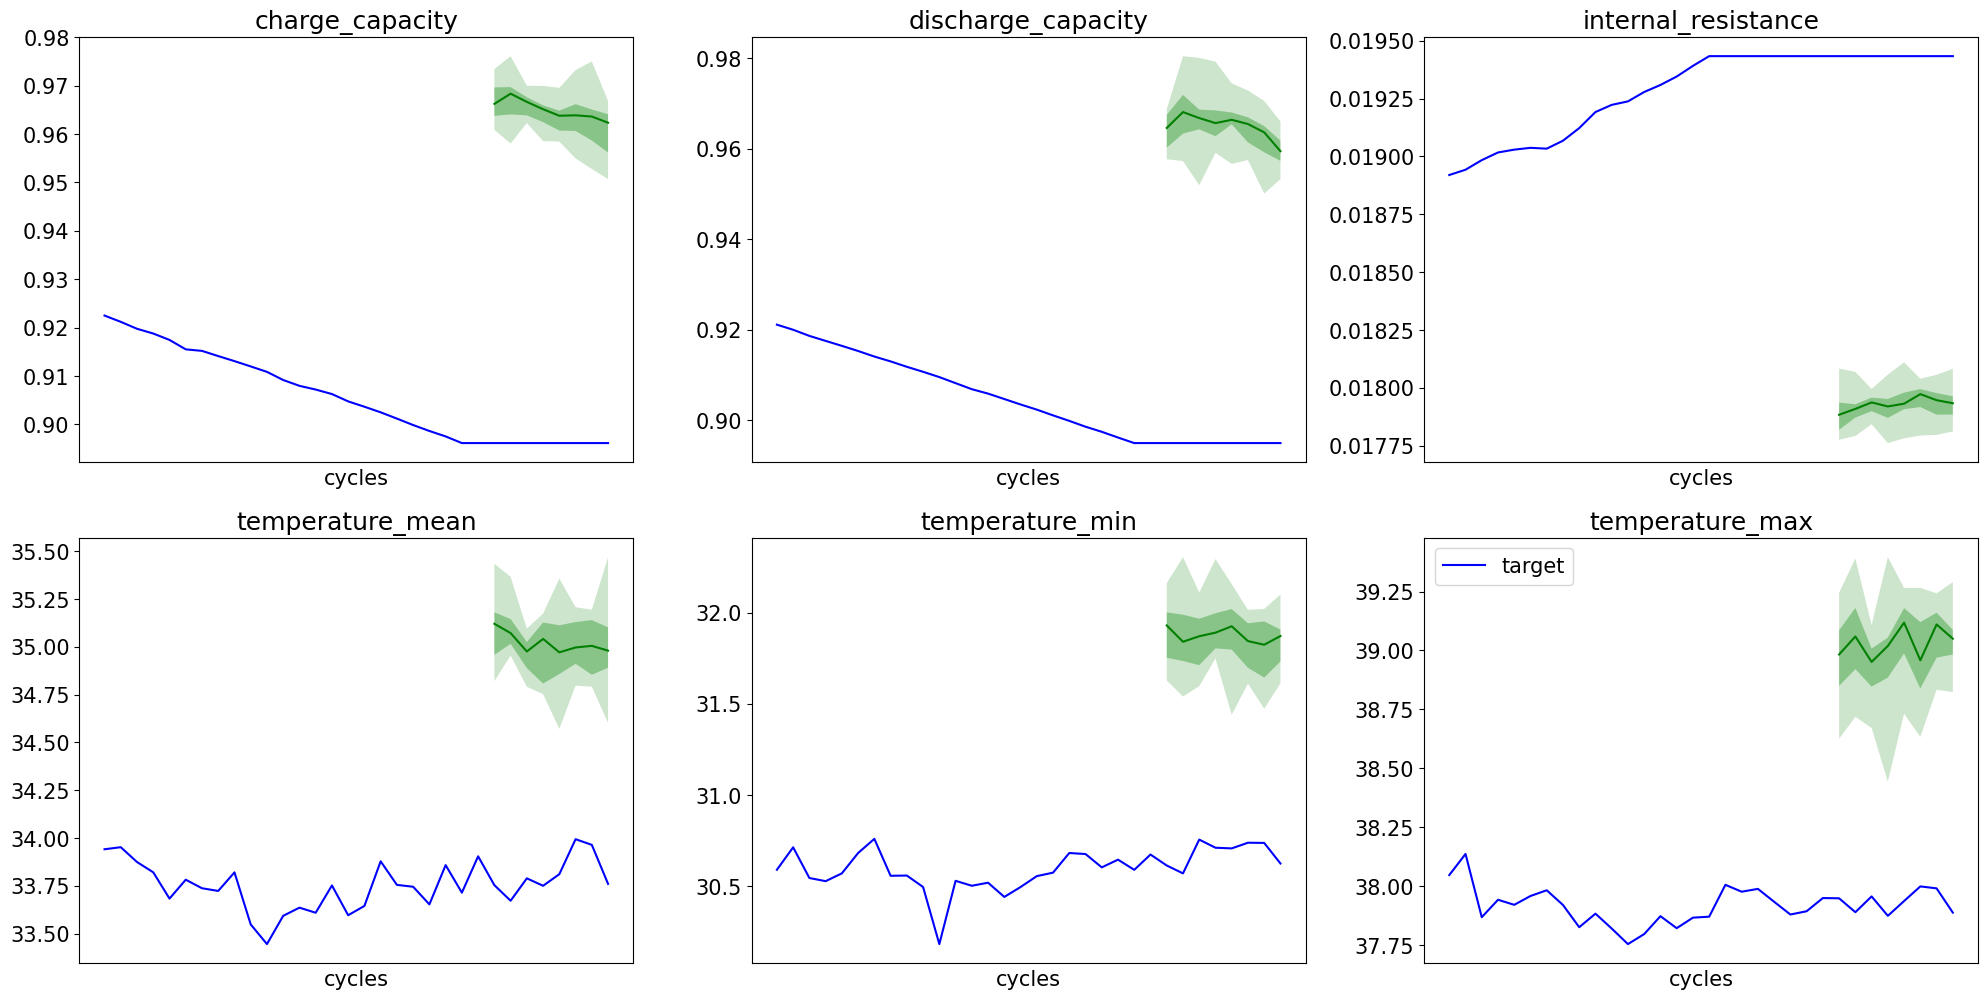

In [20]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%j')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", color='b' )
    forecast.plot( color='g')
    ax.set_xticks([])
    ax.set_xlabel("cycles")
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [28]:
ckpt_path = "/content/lag-llama/lightning_logs/version_76/checkpoints/epoch=1-step=100.ckpt"  # replace with your actual .ckpt path
loaded = torch.load(ckpt_path, map_location="cpu", weights_only=False)
hparams = loaded["hyper_parameters"]["model_kwargs"]


# 7) Instantiate the Lag-Llama estimator, pointing to your checkpoint
estimator = LagLlamaEstimator(
        ckpt_path=prev_ckpt_path,
        prediction_length=prediction_length,
        context_length=context_length,
        num_parallel_samples=num_samples,
        trainer_kwargs={
        "max_epochs": 50},

        # distr_output="neg_bin",
        # scaling="mean",
        nonnegative_pred_samples=True,
        aug_prob=0,
        lr=1e-3,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        time_feat=estimator_args["time_feat"],
        batch_size=64,
        rope_scaling=rope_scaling_arguments

    )

# 8) “Train” is simply loading the weights in zero‐shot
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
predictor = estimator.train(PandasDataset(dict(train_ds['b1c1'])))  # no new data-driven fine-tuning



INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.29309 (best -1.29309), saving model to '/content/lag-llama/lightning_logs/version_105/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -1.77726 (best -1.77726), saving model to '/content/lag-llama/lightning_logs/version_105/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' reached -1.98113 (best -1.98113), saving model to '/content/lag-llama/lightning_logs/version_105/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 200: 'train_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 250: 'train_loss' reached -2.07562 (best -2.07562), saving model to '/content/lag-llama/lightning_logs/version_105/checkpoints/epoch=4-step=250.ckpt' as top 1
INFO:pytorc

In [29]:
evaluator = Evaluator()
avg_rmse = []
avg_mae = []
avg_crps = []
for i, sid in enumerate(batch_ids):
    df = test_ds[sid]
    ds = PandasDataset(dict(df))
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=ds,
        predictor=predictor,
        num_samples=num_samples
        )
    forecasts = list(tqdm(forecast_it, total=len(ds), desc="Forecasting batches"))
    tss = list(tqdm(ts_it, total=len(ds), desc="Ground truth"))


    agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))
    avg_rmse.append(agg_metrics['RMSE'])
    avg_mae.append(agg_metrics['MAE_Coverage'])
    avg_crps.append(agg_metrics['mean_wQuantileLoss'])

print(f"Average RMSE: {sum(avg_rmse) / len(avg_rmse)}")
print(f"Average MAE: {sum(avg_mae) / len(avg_mae)}")
print(f"Average CRPS: {sum(avg_crps) / len(avg_crps)}")

Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 335.93it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 198.02it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 173.07it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 263.51it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 275.22it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 196.42it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 307.41it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 245.92it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 181.33it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 190.37it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 235.70it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 357.54it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 247.53it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 434.73it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 165.37it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 197.17it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 398.88it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 171.00it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 761.22it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 293.98it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 231.43it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 260.31it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 331.85it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 287.34it/s]


Average RMSE: 0.6828258401103852
Average MAE: 0.26147762345679015
Average CRPS: 0.024194114048745635
